In [ ]:
# Library import (core functions)

import os
import getpass

from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_community.agent_toolkits import SQLDatabaseToolkit
from langchain_community.utilities import SQLDatabase
from langchain_community.tools.sql_database.tool import QuerySQLDatabaseTool

from langgraph.prebuilt import create_react_agent

from typing import Literal
from langchain_core.messages import AIMessage
from langchain_core.runnables import RunnableConfig
from langgraph.graph import END, START, MessagesState, StateGraph
from langgraph.prebuilt import ToolNode

from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

In [ ]:
# Insert API key

if "GOOGLE_API_KEY" not in os.environ:
    os.environ["GOOGLE_API_KEY"] = getpass.getpass("Enter your Google AI API key: ")

In [3]:
# Initialize model

llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash", temperature=0)

In [4]:
# Establish database connection

db_user = "root"
db_password = "Kitsune#sql98"
db_host = "localhost"
db_name = "bank_data"

# Name of test databases
# "atliq_tshirts"
# "bank_data"

connection_Uri = f"mysql+pymysql://{db_user}:{db_password}@{db_host}/{db_name}"
db = SQLDatabase.from_uri(connection_Uri)

print(f"Dialect: {db.dialect}")
print(f"Available tables: {db.get_usable_table_names()}")

Dialect: mysql
Available tables: ['bankers', 'branch', 'credit_card', 'customer', 'loan', 'savings_account']


In [ ]:
# Tools for database interactions

toolkit = SQLDatabaseToolkit(db=db, llm=llm)
tools = toolkit.get_tools()

for tool in tools:
    print(f"{tool.name}: {tool.description}\n")

sql_db_query: Input to this tool is a detailed and correct SQL query, output is a result from the database. If the query is not correct, an error message will be returned. If an error is returned, rewrite the query, check the query, and try again. If you encounter an issue with Unknown column 'xxxx' in 'field list', use sql_db_schema to query the correct table fields.

sql_db_schema: Input to this tool is a comma-separated list of tables, output is the schema and sample rows for those tables. Be sure that the tables actually exist by calling sql_db_list_tables first! Example Input: table1, table2, table3

sql_db_list_tables: Input is an empty string, output is a comma-separated list of tables in the database.

sql_db_query_checker: Use this tool to double check if your query is correct before executing it. Always use this tool before executing a query with sql_db_query!



In [ ]:
# Using a prebuilt agent

system_prompt = """
You are an agent designed to interact with a SQL database.
Given an input question, create a syntactically correct {dialect} query to run, then look at the results of the query and return the answer.

Never query for all the columns from a specific table, only ask for the relevant columns given the question.

You MUST double check your query before executing it. If you get an error while
executing a query, rewrite the query and try again.

DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to the
database.

To start you should ALWAYS look at the tables in the database to see what you
can query. Do NOT skip this step.

Then you should query the schema of the most relevant tables.
"""

system_prompt.format(
    dialect=db.dialect
)

agent = create_react_agent(
    llm,
    tools,
    prompt=system_prompt,
)

In [7]:
# Test question

question = "In tabular format, name the client who has the highest total credit limit and its value"

for step in agent.stream(
    {"messages": [{"role": "user", "content": question}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

In tabular format, name the client who has the highest total credit limit and its value
================================== Ai Message ==================================

Okay, let's start by listing the tables in the database to understand the available data.
Tool Calls:
  sql_db_list_tables (51c4f023-dce1-4709-b9a1-c65fd1600bfa)
 Call ID: 51c4f023-dce1-4709-b9a1-c65fd1600bfa
  Args:
================================= Tool Message =================================
Name: sql_db_list_tables

bankers, branch, credit_card, customer, loan, savings_account
================================== Ai Message ==================================
Tool Calls:
  sql_db_schema (0e1668dd-c31b-49b5-a82f-9f874b8b1647)
 Call ID: 0e1668dd-c31b-49b5-a82f-9f874b8b1647
  Args:
    table_names: customer
================================= Tool Message =================================
Name: sql_db_schema


CREATE TABLE customer (
	custo

In [ ]:
# Customizing the agent

# We can enforce a higher degree of control in LangGraph by customizing the agent.
# Below, we implement a simple ReAct-agent setup, with dedicated nodes for specific tool-calls.
# We will use the same state as the pre-built agent.

# We construct dedicated nodes for the following steps:

# Listing DB tables
# Calling the "get schema" tool
# Generating a query
# Checking the query

get_schema_tool = next(tool for tool in tools if tool.name == "sql_db_schema")
get_schema_node = ToolNode([get_schema_tool], name="get_schema")

run_query_tool = next(tool for tool in tools if tool.name == "sql_db_query")
run_query_node = ToolNode([run_query_tool], name="run_query")


# Example: create a predetermined tool call
def list_tables(state: MessagesState):
    tool_call = {
        "name": "sql_db_list_tables",
        "args": {},
        "id": "abc123",
        "type": "tool_call",
    }
    tool_call_message = AIMessage(content="", tool_calls=[tool_call])

    list_tables_tool = next(tool for tool in tools if tool.name == "sql_db_list_tables")
    tool_message = list_tables_tool.invoke(tool_call)
    response = AIMessage(f"Available tables: {tool_message.content}")

    return {"messages": [tool_call_message, tool_message, response]}


# Example: force a model to create a tool call
def call_get_schema(state: MessagesState):
    # Note that LangChain enforces that all models accept `tool_choice="any"`
    # as well as `tool_choice=<string name of tool>`.
    llm_with_tools = llm.bind_tools([get_schema_tool], tool_choice="any")
    response = llm_with_tools.invoke(state["messages"])

    return {"messages": [response]}


generate_query_system_prompt = """
You are an agent designed to interact with a SQL database.
Given an input question, create a syntactically correct {dialect} query to run, then look at the results of the query and return the answer.

Never query for all the columns from a specific table, only ask for the relevant columns given the question.

You MUST double check your query before executing it. If you get an error while
executing a query, rewrite the query and try again.

DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to the
database.

To start you should ALWAYS look at the tables in the database to see what you
can query. Do NOT skip this step.

Then you should query the schema of the most relevant tables.
""".format(
    dialect=db.dialect
)


def generate_query(state: MessagesState):
    system_message = {
        "role": "system",
        "content": generate_query_system_prompt,
    }
    # We do not force a tool call here, to allow the model to
    # respond naturally when it obtains the solution.
    llm_with_tools = llm.bind_tools([run_query_tool])
    response = llm_with_tools.invoke([system_message] + state["messages"])

    return {"messages": [response]}


check_query_system_prompt = """
You are a SQL expert with a strong attention to detail.
Double check the {dialect} query for common mistakes, including:
- Using NOT IN with NULL values
- Using UNION when UNION ALL should have been used
- Using BETWEEN for exclusive ranges
- Data type mismatch in predicates
- Properly quoting identifiers
- Using the correct number of arguments for functions
- Casting to the correct data type
- Using the proper columns for joins

If there are any of the above mistakes, rewrite the query. If there are no mistakes,
just reproduce the original query.

Don't limit the query output.

You will call the appropriate tool to execute the query after running this check.
""".format(dialect=db.dialect)


def check_query(state: MessagesState):
    system_message = {
        "role": "system",
        "content": check_query_system_prompt,
    }

    # Generate an artificial user message to check
    tool_call = state["messages"][-1].tool_calls[0] # type: ignore
    user_message = {"role": "user", "content": tool_call["args"]["query"]}
    llm_with_tools = llm.bind_tools([run_query_tool], tool_choice="any")
    response = llm_with_tools.invoke([system_message, user_message])
    response.id = state["messages"][-1].id

    return {"messages": [response]}

In [9]:
# Assemble these steps into a workflow using the Graph API.

def should_continue(state: MessagesState) -> Literal[END, "check_query"]: # type: ignore
    messages = state["messages"]
    last_message = messages[-1]
    if not last_message.tool_calls: # type: ignore
        return END
    else:
        return "check_query"


builder = StateGraph(MessagesState)
builder.add_node(list_tables)
builder.add_node(call_get_schema)
builder.add_node(get_schema_node, "get_schema") # type: ignore
builder.add_node(generate_query)
builder.add_node(check_query)
builder.add_node(run_query_node, "run_query") # type: ignore

builder.add_edge(START, "list_tables")
builder.add_edge("list_tables", "call_get_schema")
builder.add_edge("call_get_schema", "get_schema")
builder.add_edge("get_schema", "generate_query")
builder.add_conditional_edges(
    "generate_query",
    should_continue,
)
builder.add_edge("check_query", "run_query")
builder.add_edge("run_query", "generate_query")

agent = builder.compile()

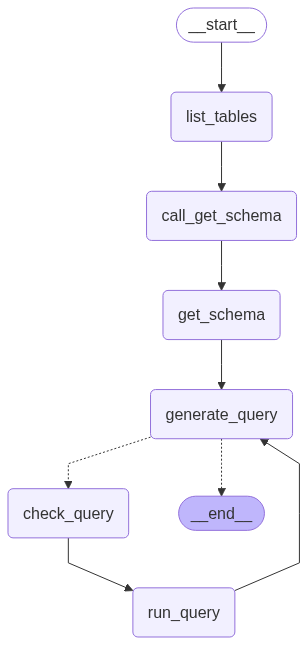

In [ ]:
display(Image(agent.get_graph().draw_mermaid_png()))

In [13]:
question = """
Para clientes con ahorros mayores a cero, proporciona: Nombre, cantidad de tarjetas de crédito, límite total de crédito. Ordena los datos de límite total en orden descendente y muestra los resultados en formato tabular.
"""

# "Which account has the lowest balance, what is the client name and who is the branch banker?"
# "What is the total balance of all the accounts in the database and list those customers with an active loan?"
# "Name of the client with most number of credit cards, how many and total limit."

for step in agent.stream(
    {"messages": [{"role": "user", "content": question}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================


Para clientes con ahorros mayores a cero, proporciona: Nombre, cantidad de tarjetas de crédito, límite total de crédito. Ordena los datos de límite total en orden descendente y muestra los resultados en formato tabular.

================================== Ai Message ==================================

Available tables: bankers, branch, credit_card, customer, loan, savings_account
================================== Ai Message ==================================
Tool Calls:
  sql_db_schema (ae345c1c-cd5b-430d-af7a-389f8221c7c6)
 Call ID: ae345c1c-cd5b-430d-af7a-389f8221c7c6
  Args:
    table_names: customer, credit_card, savings_account
================================= Tool Message =================================
Name: sql_db_schema


CREATE TABLE credit_card (
	credit_card_number VARCHAR(19) CHARACTER SET utf8mb3 COLLATE utf8mb3_general_ci, 
	customer_id INTEGER, 
	currency VARCHAR(3) CHARACTER SET utf8